# Inspect the single-lineage model run on the prostate data (003)

Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qnorm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-prostate-003_PYMC_NUMPYRO"

In [6]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

name: 'hnb-single-lineage-prostate-003'
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-prostate-003",
    "description": " Single lineage hierarchical negative binomial model for prostate data from the Broad. This model modifies the one used for 002 by using a Gamma distribution for the SD of the varying gene effect multivariate normal instead of a an Exponential. This shifts the prior distribution away from 0 to hopefully help with stability. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_prostate.csv",
    "model_kwargs": {
        "lineage": "prostate"
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 1000,
            "chains": 4,
            "target_accept": 0.999,
         

### Load posterior summary

In [7]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

parameter    mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a   0.100  0.002     0.097      0.102      0.000    0.000     483.0   
1      mu_b  -0.001  0.001    -0.002      0.000      0.000    0.000     308.0   
2      mu_d  -0.020  0.001    -0.021     -0.019      0.000    0.000    1170.0   
3   sigma_a   0.211  0.001     0.210      0.213      0.000    0.000     912.0   
4     alpha  12.491  0.039    12.425     12.549      0.004    0.003      97.0   

   ess_tail  r_hat var_name  
0    2568.0   1.03  mu_mu_a  
1    2208.0   1.02     mu_b  
2    1752.0   1.01     mu_d  
3    2038.0   1.01  sigma_a  
4     717.0   1.04    alpha

### Load trace object

In [8]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [9]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[_broad_only],
)

In [10]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [11]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [12]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[07/29/22 06:43:20] INFO     Processing data for modeling.     ]8;id=631640;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=9673;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=97420;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=766167;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#270\270]8;;\

[07/29/22 06:44:21] WARNING  number of data points dropped: 2  ]8;id=668035;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=165129;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#321\321]8;;\

[07/29/22 06:44:22] INFO     number of genes mutated in all    ]8;id=460213;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=679429;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#470\470]8;;\
                             cells lines: 0                                                  

                    INFO     Dropping 8 cancer genes.          ]8;id=434966;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=672061;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#526\526]8;;\

## Analysis

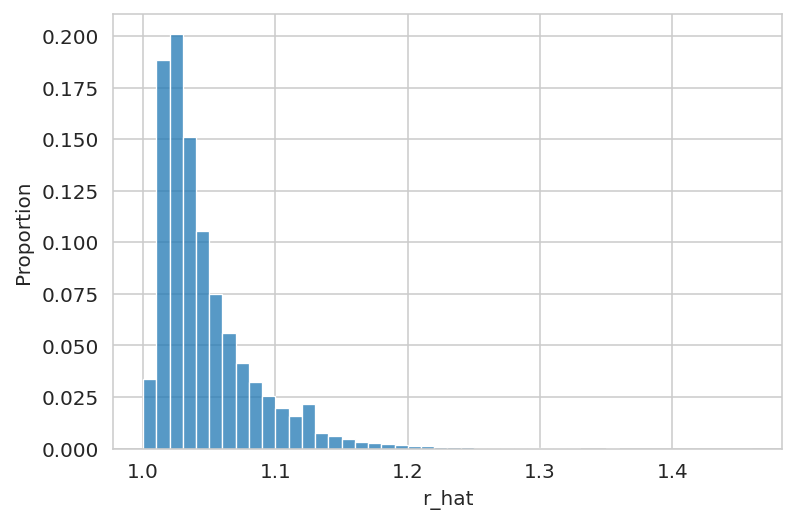

In [13]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

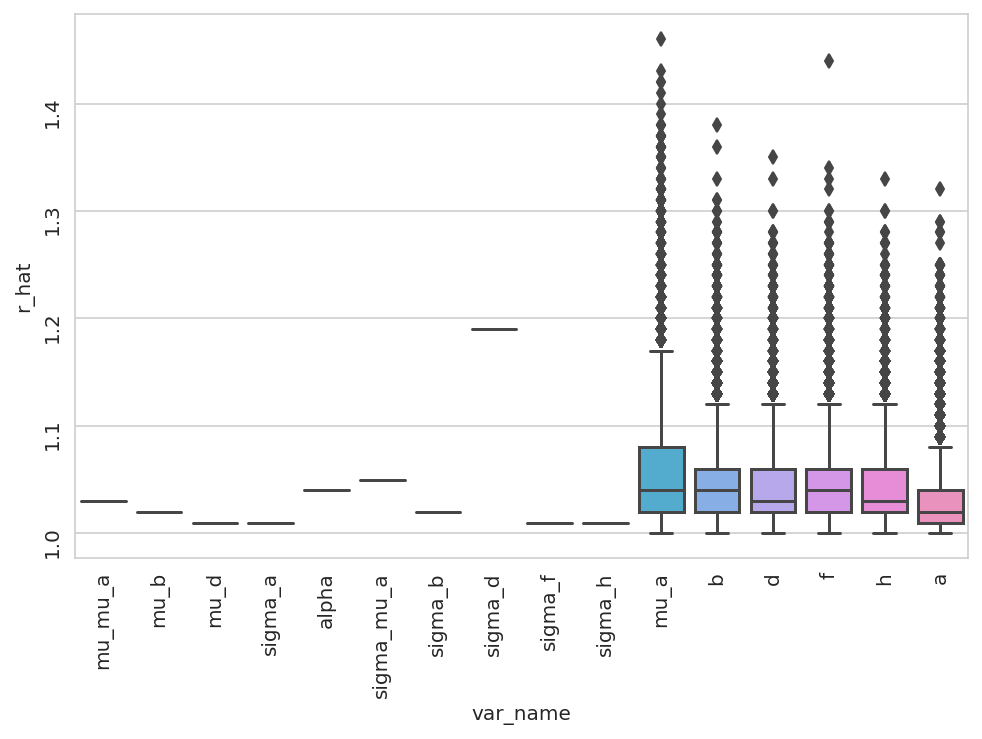

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

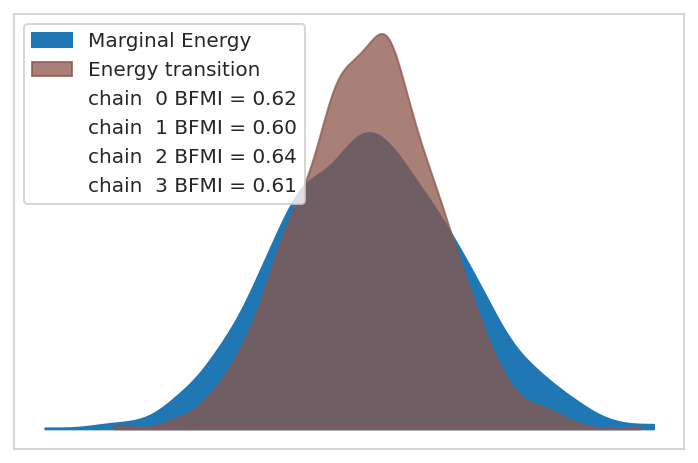

In [15]:
az.plot_energy(trace);

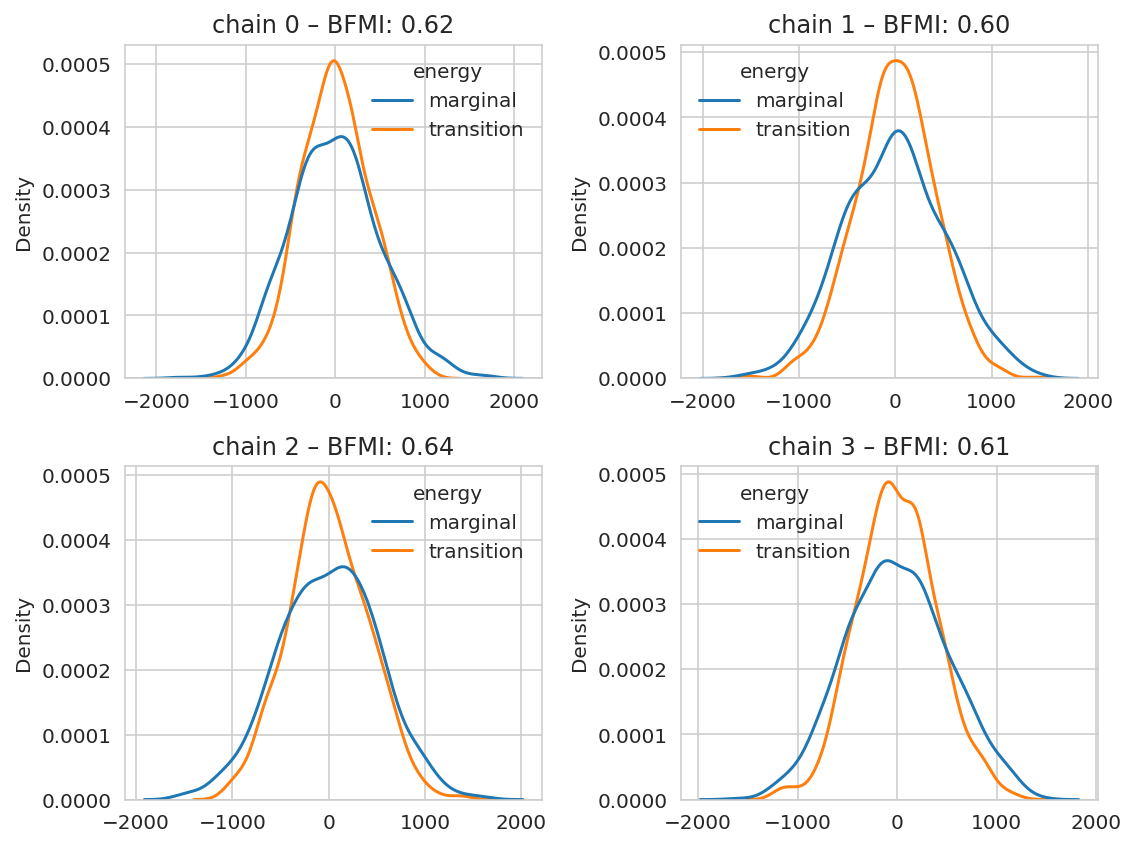

In [16]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

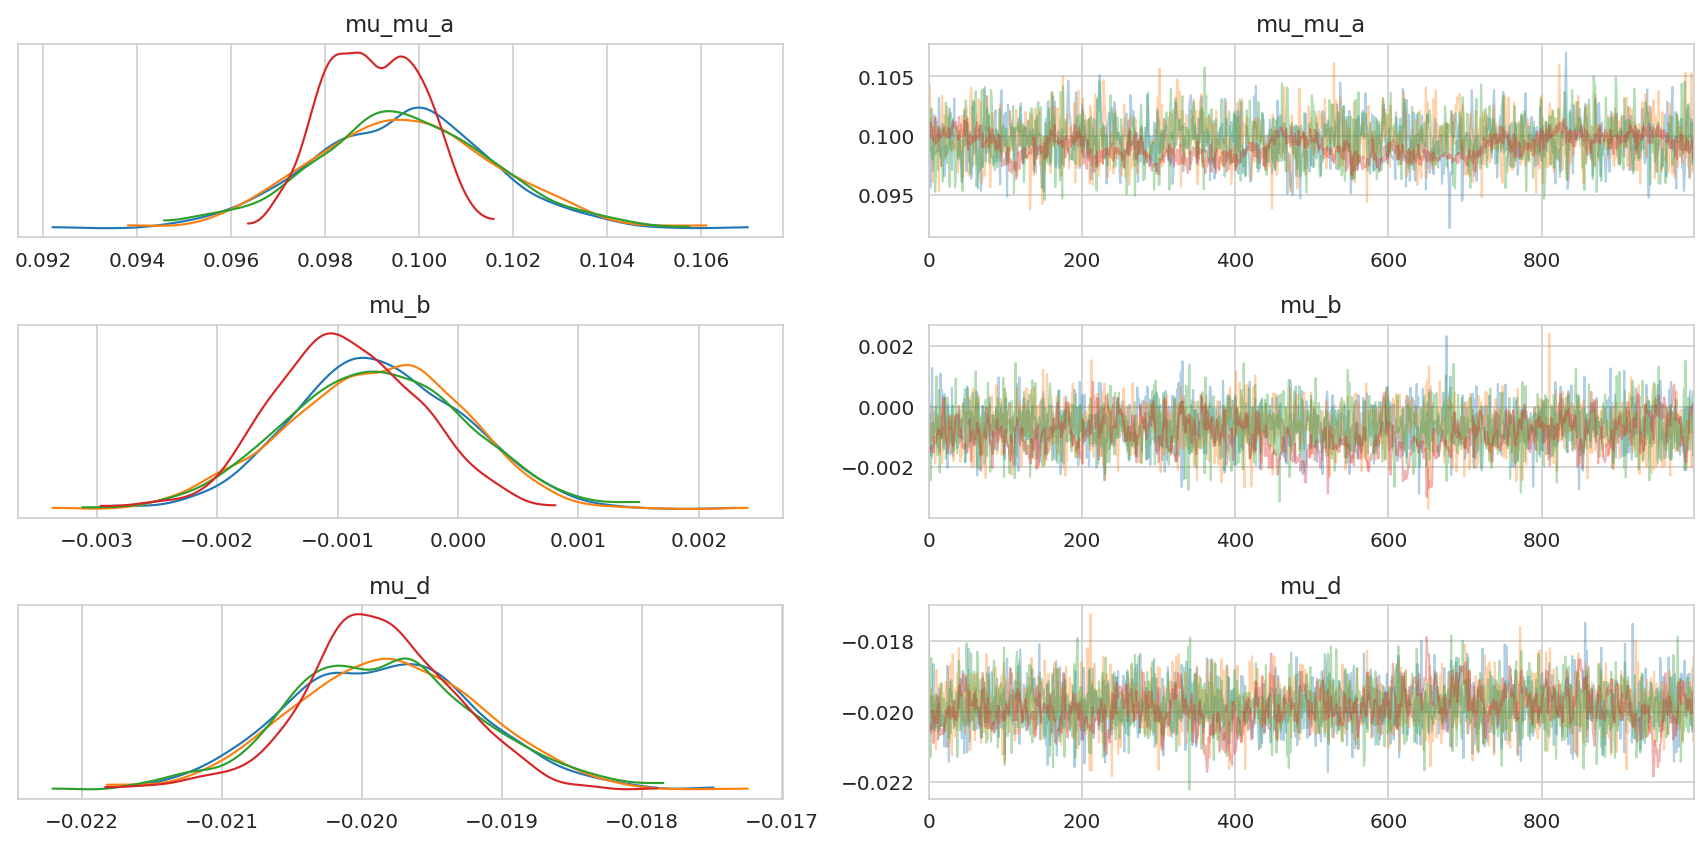

In [17]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_d"], compact=False)
plt.tight_layout()

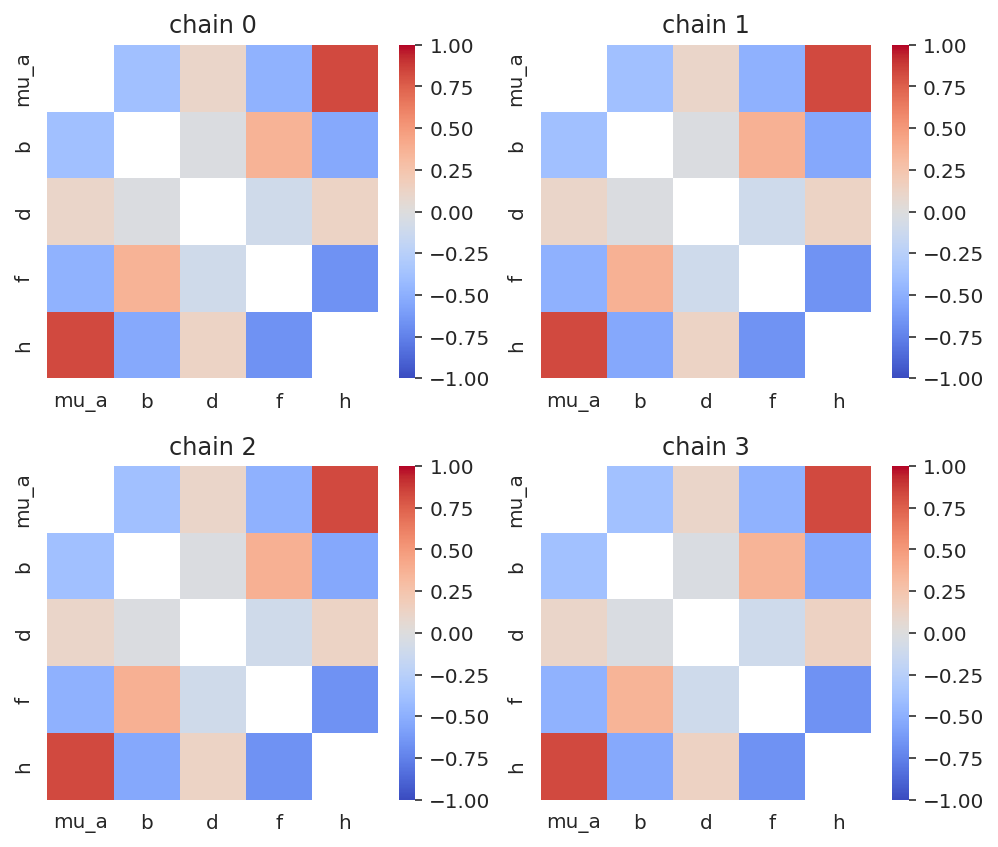

In [18]:
genes_var_corr = trace.posterior["genes_chol_cov_corr"].mean(axis=(1))
genes_var_names = ["mu_a", "b", "d", "f", "h"]
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

for c, ax in enumerate(axes.flatten()):
    data = genes_var_corr[c, :, :].values.copy()
    np.fill_diagonal(data, np.nan)
    sns.heatmap(data, vmin=-1, vmax=1, cmap="coolwarm", ax=ax)
    ax.set_xticklabels(genes_var_names)
    ax.set_yticklabels(genes_var_names)
    ax.set_title(f"chain {c}")

fig.tight_layout()
plt.show()

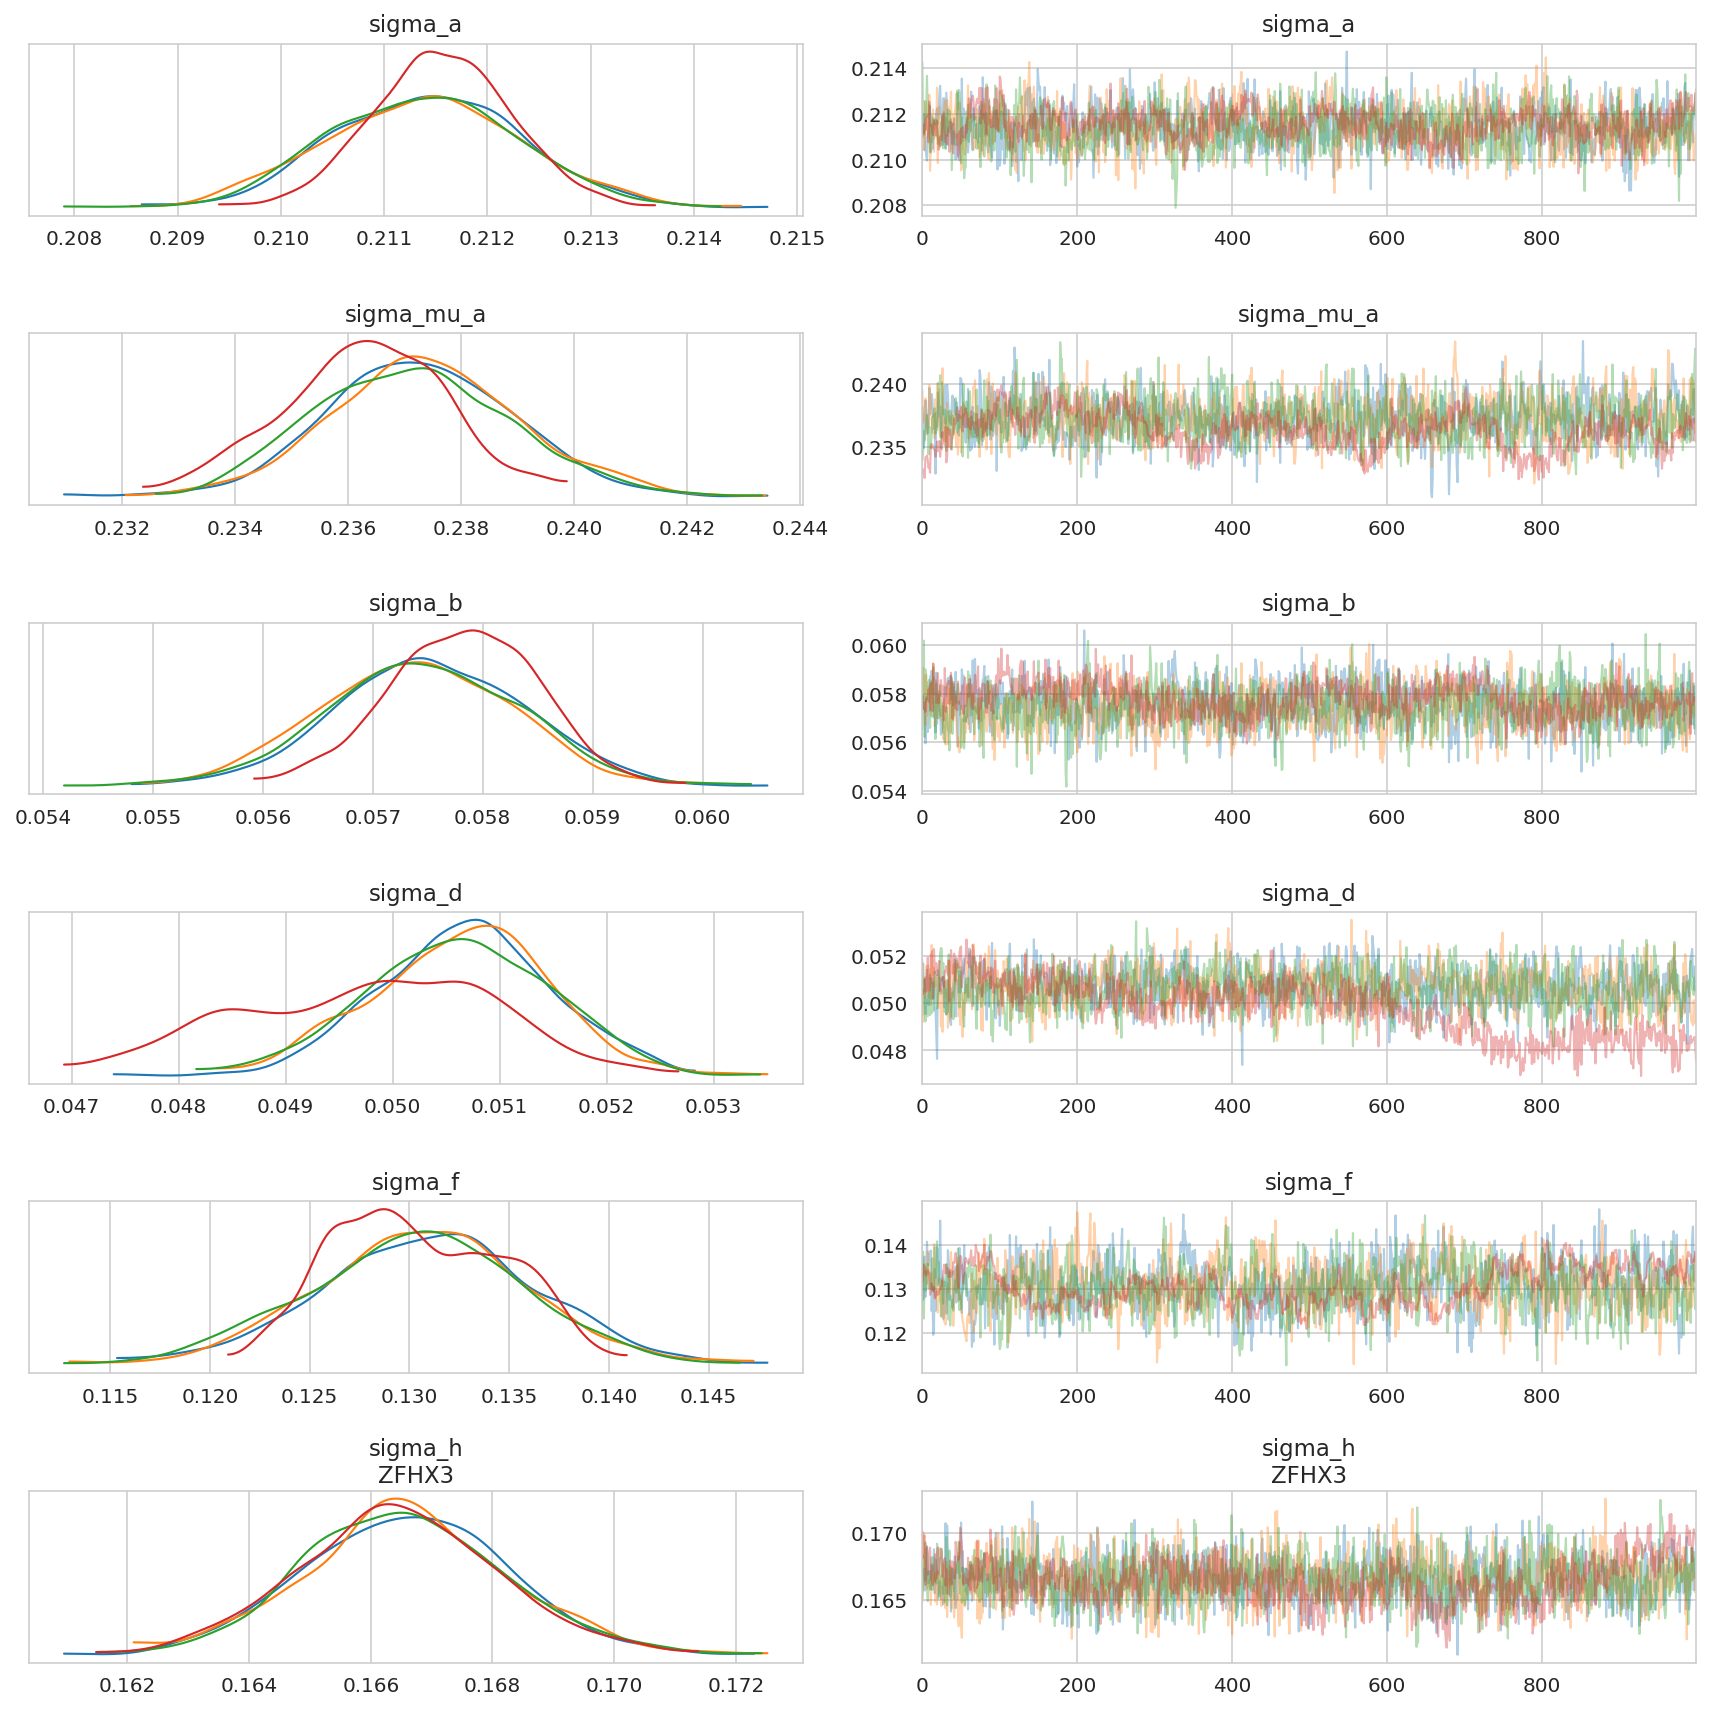

In [20]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [21]:
trace.posterior["sigma_a"].mean(axis=1).values

array([0.21142235, 0.21137959, 0.21136671, 0.21155286])

In [22]:
trace.posterior["sigma_mu_a"].mean(axis=1).values

array([0.23726531, 0.23738346, 0.2371463 , 0.23627266])

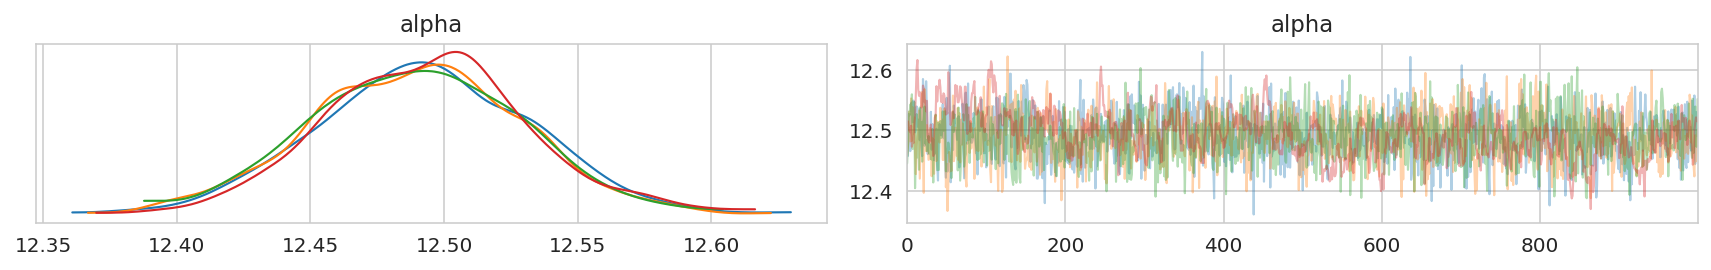

In [23]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()

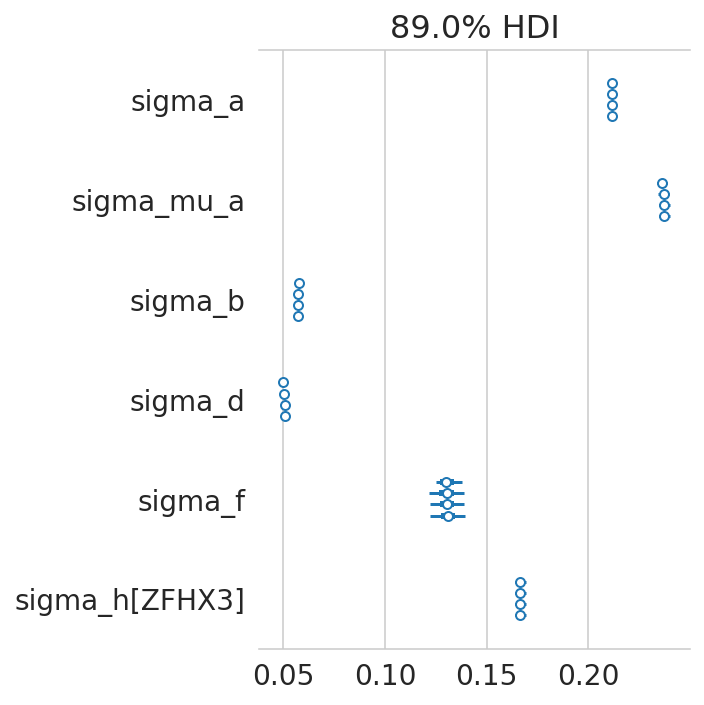

In [24]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 5)
)
plt.tight_layout()

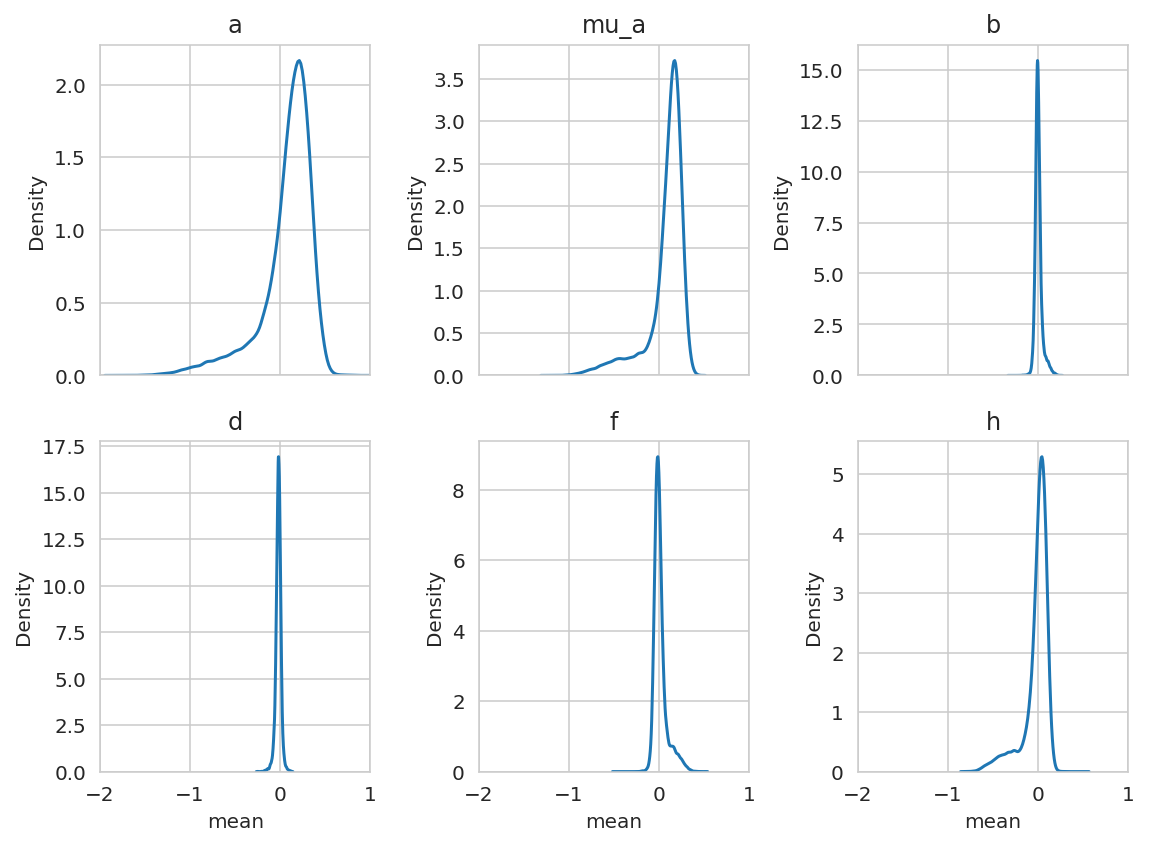

In [25]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [26]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [27]:
prostate_post_summary.query("var_name == 'mu_a'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
7784      mu_a[KIF11] -1.222  0.100    -1.388     -1.071      0.004    0.003   
6986      mu_a[HSPE1] -1.047  0.090    -1.190     -0.903      0.003    0.002   
14743     mu_a[SPC24] -1.038  0.095    -1.188     -0.887      0.006    0.005   
13209     mu_a[RPL12] -1.027  0.095    -1.172     -0.865      0.008    0.006   
4543       mu_a[EEF2] -1.023  0.097    -1.174     -0.867      0.007    0.005   
13764  mu_a[SERPINA7]  0.398  0.107     0.239      0.585      0.013    0.010   
17715    mu_a[ZNF334]  0.399  0.100     0.239      0.549      0.012    0.009   
6761   mu_a[HLA-DQB1]  0.400  0.101     0.254      0.566      0.006    0.005   
939    mu_a[ARHGAP44]  0.403  0.097     0.248      0.555      0.016    0.011   
16213      mu_a[TP53]  0.420  0.090     0.269      0.559      0.008    0.006   

       ess_bulk  ess_tail  r_hat var_name  
7784      493.0    1363.0   1.00     mu_a  
6986      825.0    1440.0   1.01     mu_a  
14743     254.0     549.0   1.02     mu_a  
13209     150.0     397.0   1.03     mu_a  
4543      205.0     236.0   1.01     mu_a  
13764      70.0      99.0   1.05     mu_a  
17715      66.0    1044.0   1.05     mu_a  
6761      249.0     800.0   1.00     mu_a  
939        39.0     263.0   1.07     mu_a  
16213     116.0    1562.0   1.03     mu_a

In [28]:
prostate_post_summary.query("var_name == 'b'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
22901    b[EP300] -0.319  0.042    -0.388     -0.255      0.002    0.001   
34343     b[TP63] -0.179  0.043    -0.242     -0.106      0.006    0.004   
33097    b[STAG2] -0.178  0.042    -0.249     -0.112      0.009    0.006   
22613      b[EBP] -0.173  0.044    -0.242     -0.104      0.005    0.003   
33382    b[TADA1] -0.170  0.041    -0.231     -0.103      0.007    0.005   
19385  b[ATP6V1F]  0.216  0.041     0.157      0.283      0.003    0.002   
27506   b[MRPL57]  0.229  0.041     0.163      0.295      0.005    0.003   
24315      b[GPI]  0.241  0.042     0.174      0.307      0.002    0.002   
18590    b[AIFM1]  0.253  0.045     0.180      0.321      0.004    0.003   
27883    b[NARS2]  0.254  0.040     0.188      0.315      0.004    0.003   

       ess_bulk  ess_tail  r_hat var_name  
22901     444.0     682.0   1.01        b  
34343      50.0     174.0   1.06        b  
33097      24.0      65.0   1.11        b  
22613      96.0    1852.0   1.03        b  
33382      37.0     248.0   1.09        b  
19385     183.0     533.0   1.02        b  
27506      79.0     492.0   1.03        b  
24315     356.0    2132.0   1.01        b  
18590     156.0     145.0   1.02        b  
27883     125.0     456.0   1.03        b

In [29]:
prostate_post_summary.query("var_name == 'd'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
39173   d[CHMP3] -0.254  0.036    -0.315     -0.201      0.002    0.002   
37444  d[ATP1A1] -0.249  0.041    -0.313     -0.186      0.005    0.004   
52639   d[TRIT1] -0.212  0.038    -0.280     -0.157      0.003    0.002   
44641   d[LONP1] -0.207  0.036    -0.262     -0.146      0.003    0.002   
52954   d[UBE2N] -0.205  0.039    -0.272     -0.148      0.003    0.002   
42785    d[HCCS]  0.119  0.043     0.046      0.184      0.004    0.003   
40991    d[ENO1]  0.120  0.042     0.055      0.186      0.004    0.003   
51555   d[TARS2]  0.122  0.038     0.060      0.181      0.001    0.001   
45607  d[MRPL39]  0.127  0.038     0.066      0.186      0.002    0.001   
40412   d[DMAC1]  0.128  0.042     0.060      0.193      0.004    0.003   

       ess_bulk  ess_tail  r_hat var_name  
39173     314.0     420.0   1.00        d  
37444      66.0     857.0   1.05        d  
52639     229.0     573.0   1.02        d  
44641     146.0     643.0   1.03        d  
52954     143.0     331.0   1.01        d  
42785     136.0     207.0   1.03        d  
40991     141.0      96.0   1.04        d  
51555     707.0    1606.0   1.01        d  
45607     415.0     859.0   1.01        d  
40412     101.0     237.0   1.03        d

In [30]:
prostate_post_summary.query("var_name == 'h'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
77154       h[ELL, ZFHX3] -0.799  0.079    -0.921     -0.667      0.005   
80260     h[KIF11, ZFHX3] -0.786  0.084    -0.922     -0.652      0.005   
88899     h[TRNT1, ZFHX3] -0.777  0.084    -0.901     -0.635      0.015   
80879     h[LONP1, ZFHX3] -0.743  0.084    -0.876     -0.611      0.003   
73736  h[ATP6V1B2, ZFHX3] -0.729  0.083    -0.856     -0.591      0.006   
86240  h[SERPINA7, ZFHX3]  0.229  0.078     0.102      0.346      0.013   
72882      h[AFF4, ZFHX3]  0.229  0.075     0.112      0.346      0.014   
77165      h[ELOA, ZFHX3]  0.260  0.068     0.154      0.369      0.003   
88689      h[TP53, ZFHX3]  0.287  0.076     0.161      0.403      0.010   
77258     h[EP300, ZFHX3]  0.504  0.077     0.377      0.623      0.005   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name  
77154    0.003     297.0    2304.0   1.02        h  
80260    0.004     235.0    2710.0   1.02        h  
88899    0.011      33.0     786.0   1.08        h  
80879    0.002     767.0    1915.0   1.01        h  
73736    0.004     174.0     346.0   1.02        h  
86240    0.009      38.0    1251.0   1.07        h  
72882    0.010      30.0     956.0   1.09        h  
77165    0.002     671.0    2166.0   1.04        h  
88689    0.007      57.0     425.0   1.06        h  
77258    0.004     220.0     804.0   1.01        h

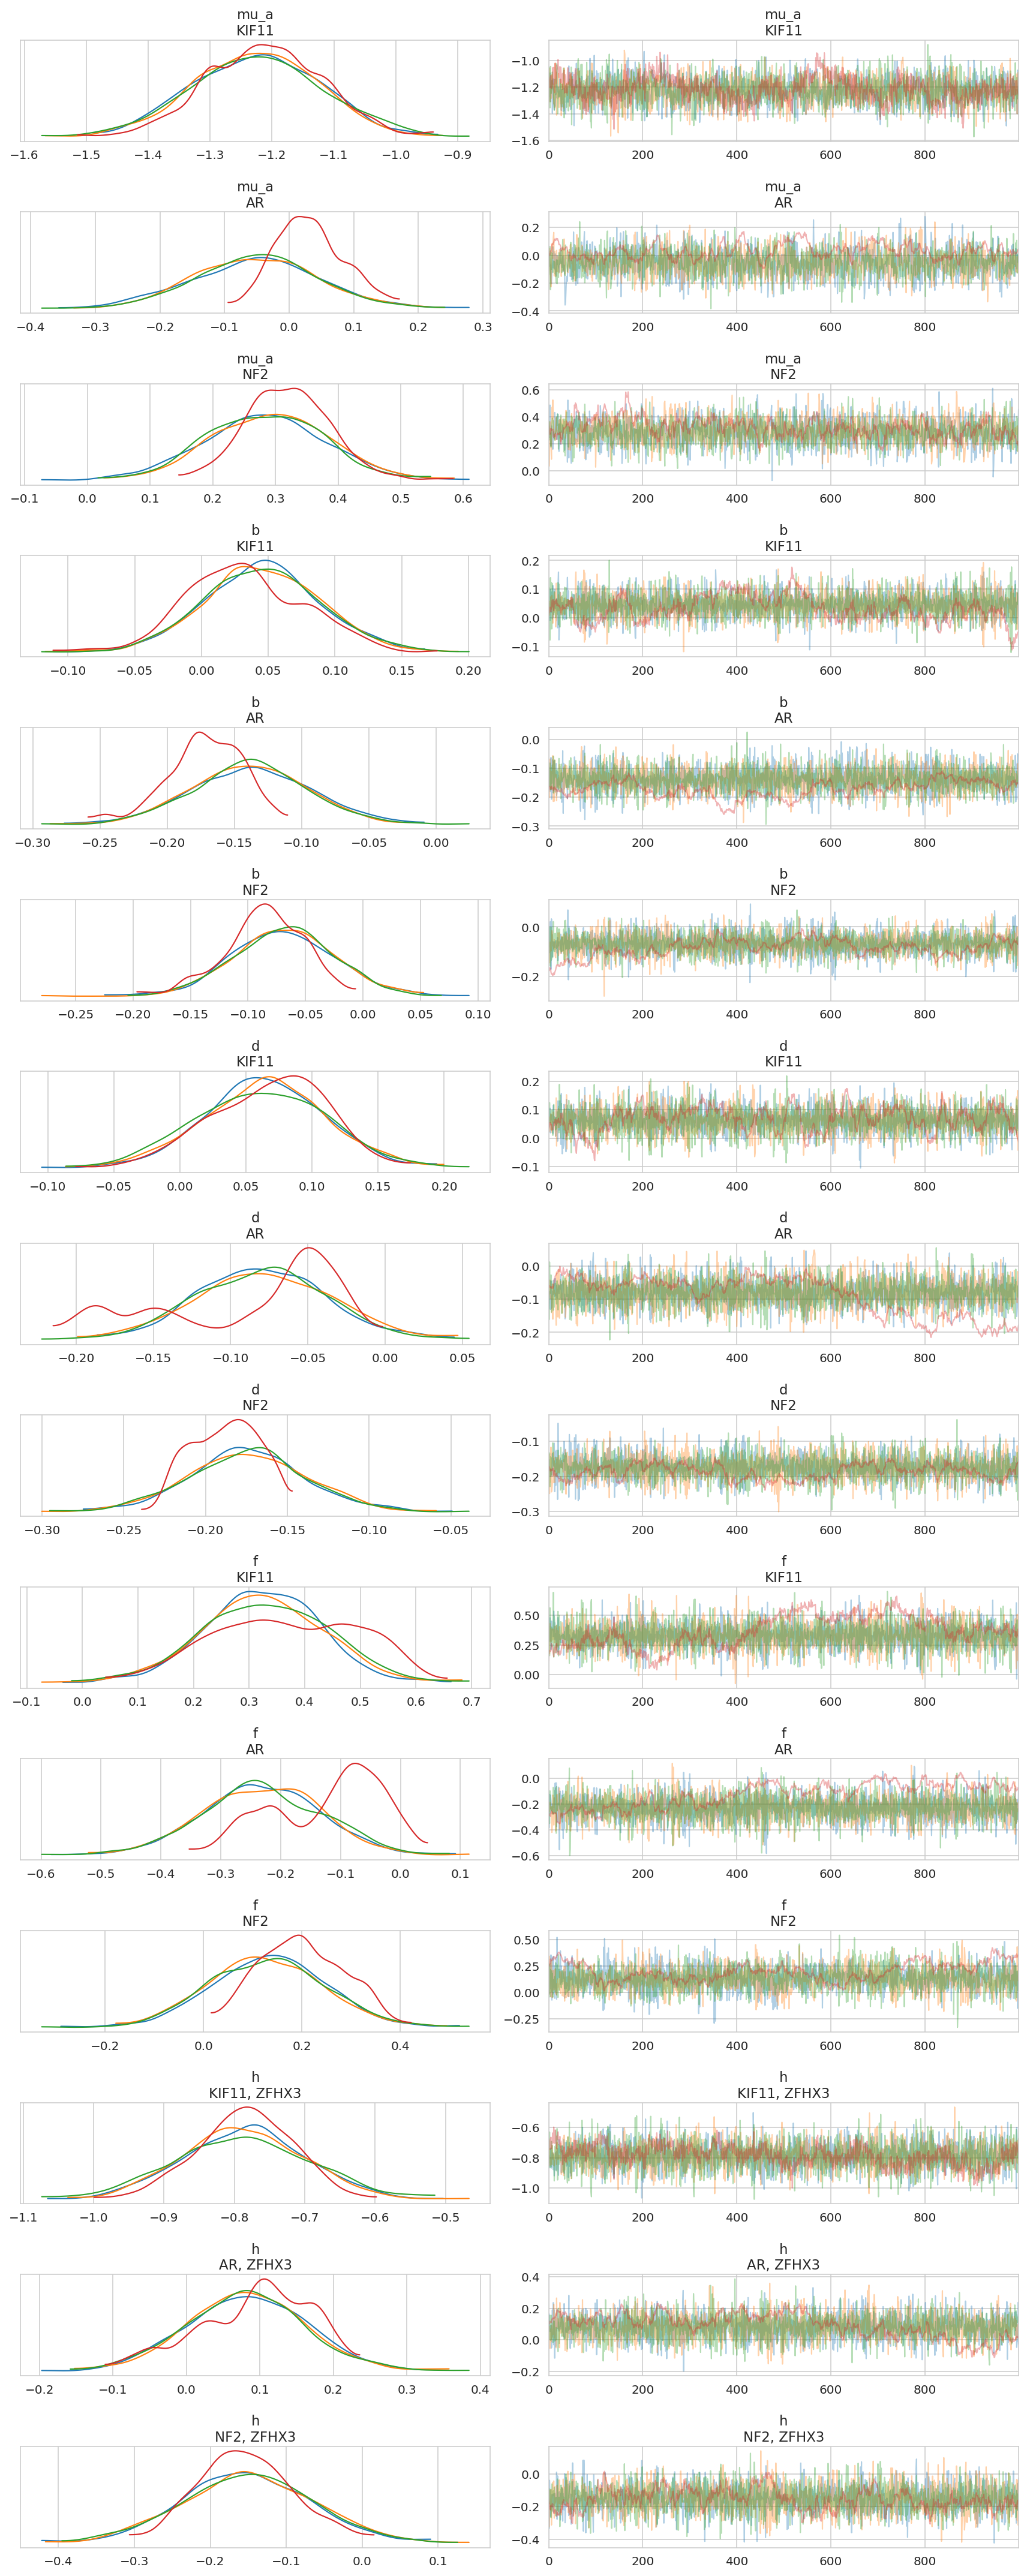

In [31]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace,
    var_names=["mu_a", "b", "d", "f", "h"],
    coords={"gene": example_genes},
    compact=False,
)
plt.tight_layout()
plt.show()

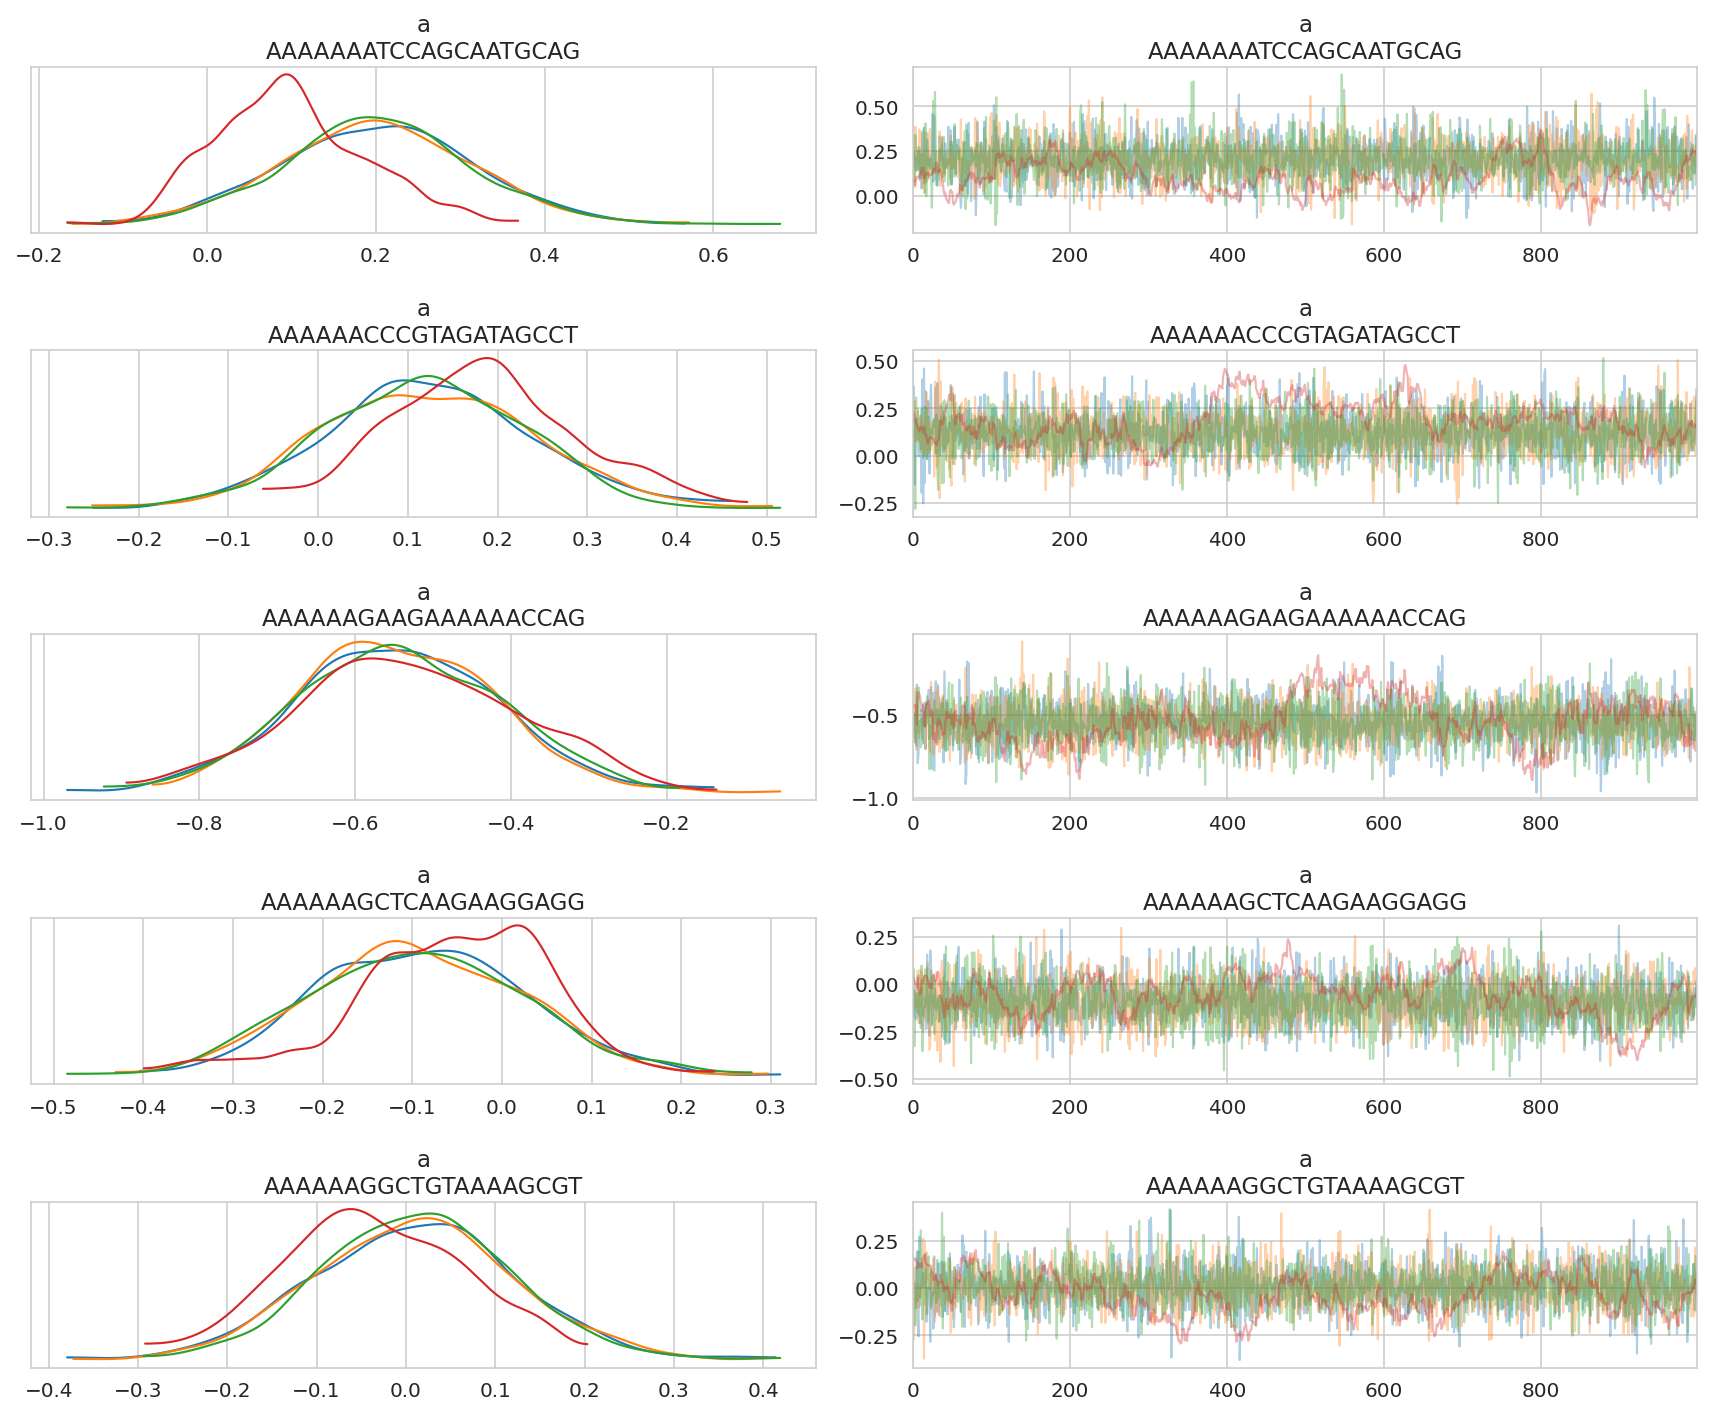

In [32]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

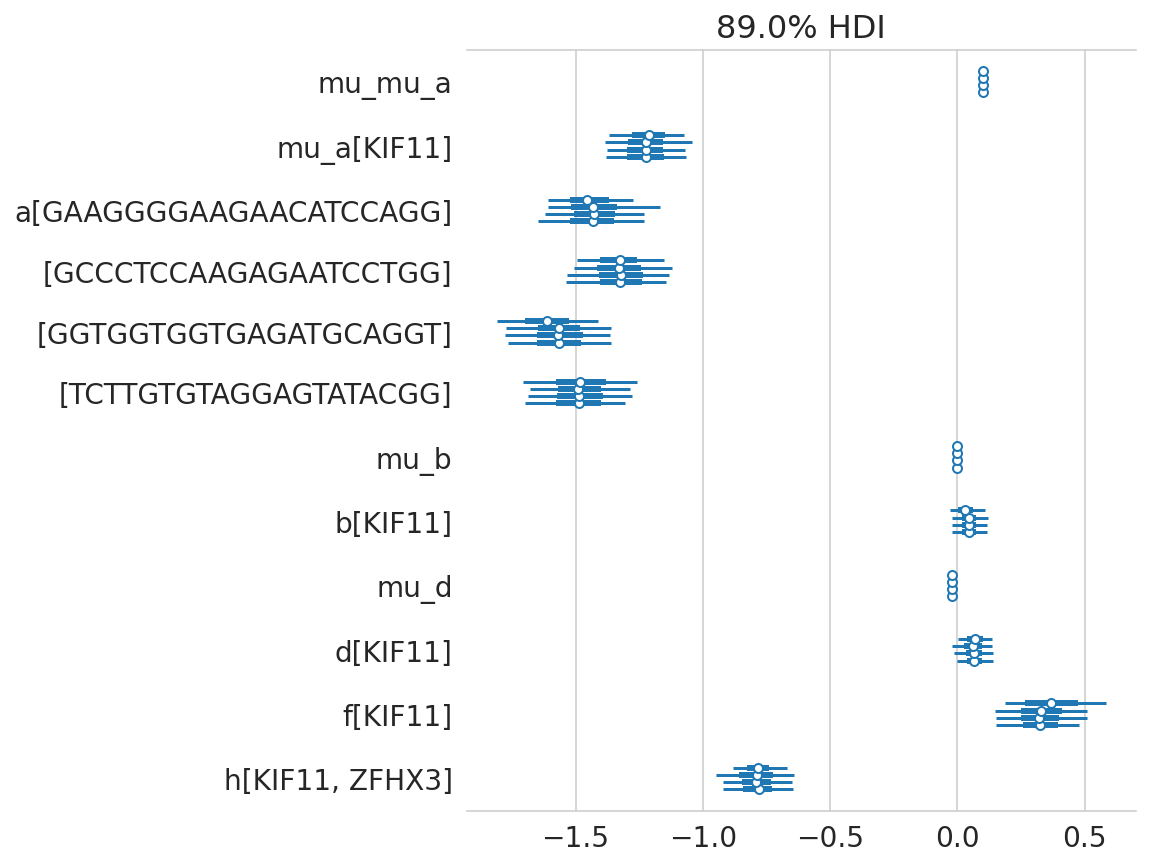

In [33]:
example_gene = "KIF11"
example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
    "sgrna"
].tolist()
az.plot_forest(
    trace,
    var_names=[
        "mu_mu_a",
        "mu_a",
        "a",
        "mu_b",
        "b",
        "mu_d",
        "d",
        # "mu_f",
        "f",
        "h",
    ],
    coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
    combined=False,
    figsize=(6, 7),
)
plt.show()

In [34]:
prostate_post_summary.filter_string("var_name", "^sigma_*")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
3         sigma_a  0.211  0.001     0.210      0.213        0.0      0.0   
5      sigma_mu_a  0.237  0.002     0.234      0.240        0.0      0.0   
6         sigma_b  0.058  0.001     0.056      0.059        0.0      0.0   
7         sigma_d  0.050  0.001     0.049      0.052        0.0      0.0   
8         sigma_f  0.131  0.005     0.123      0.139        0.0      0.0   
9  sigma_h[ZFHX3]  0.167  0.002     0.164      0.169        0.0      0.0   

   ess_bulk  ess_tail  r_hat    var_name  
3     912.0    2038.0   1.01     sigma_a  
5      71.0     357.0   1.05  sigma_mu_a  
6     166.0    1952.0   1.02     sigma_b  
7      15.0      13.0   1.19     sigma_d  
8     237.0    1391.0   1.01     sigma_f  
9     293.0    1239.0   1.01     sigma_h

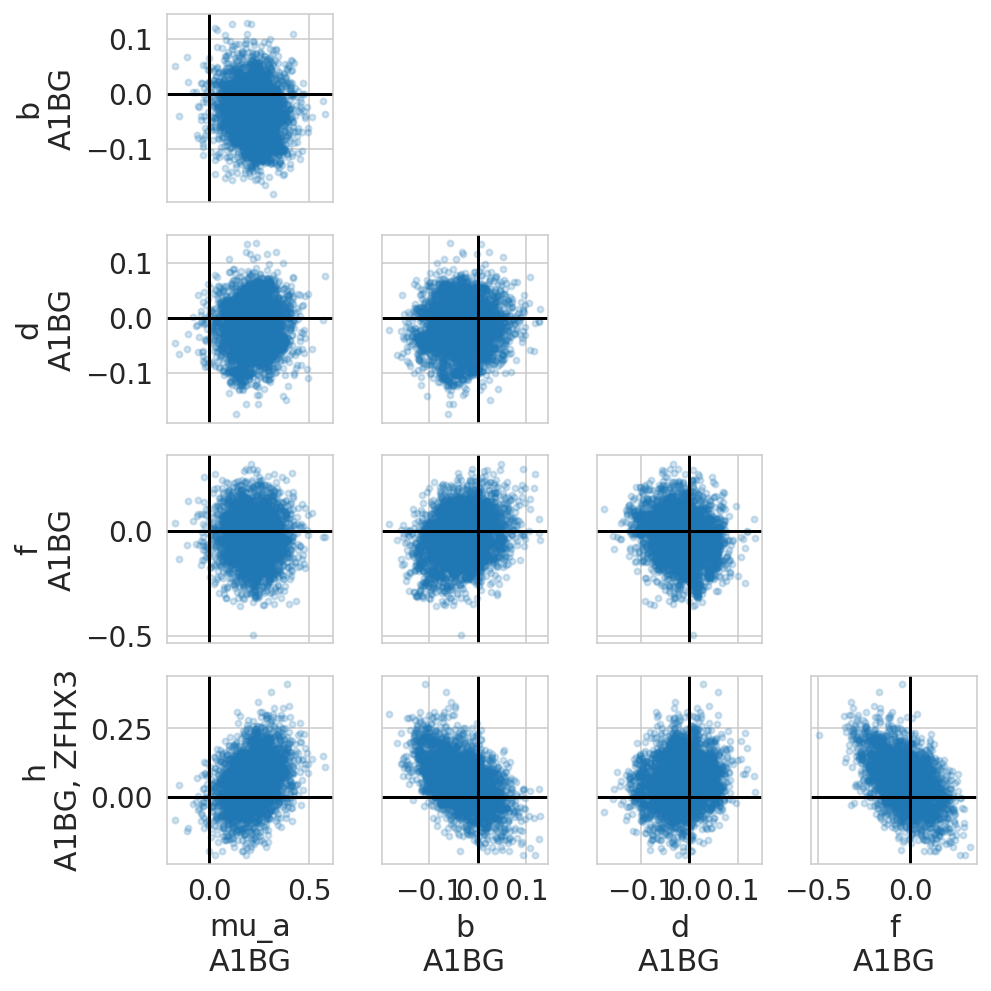

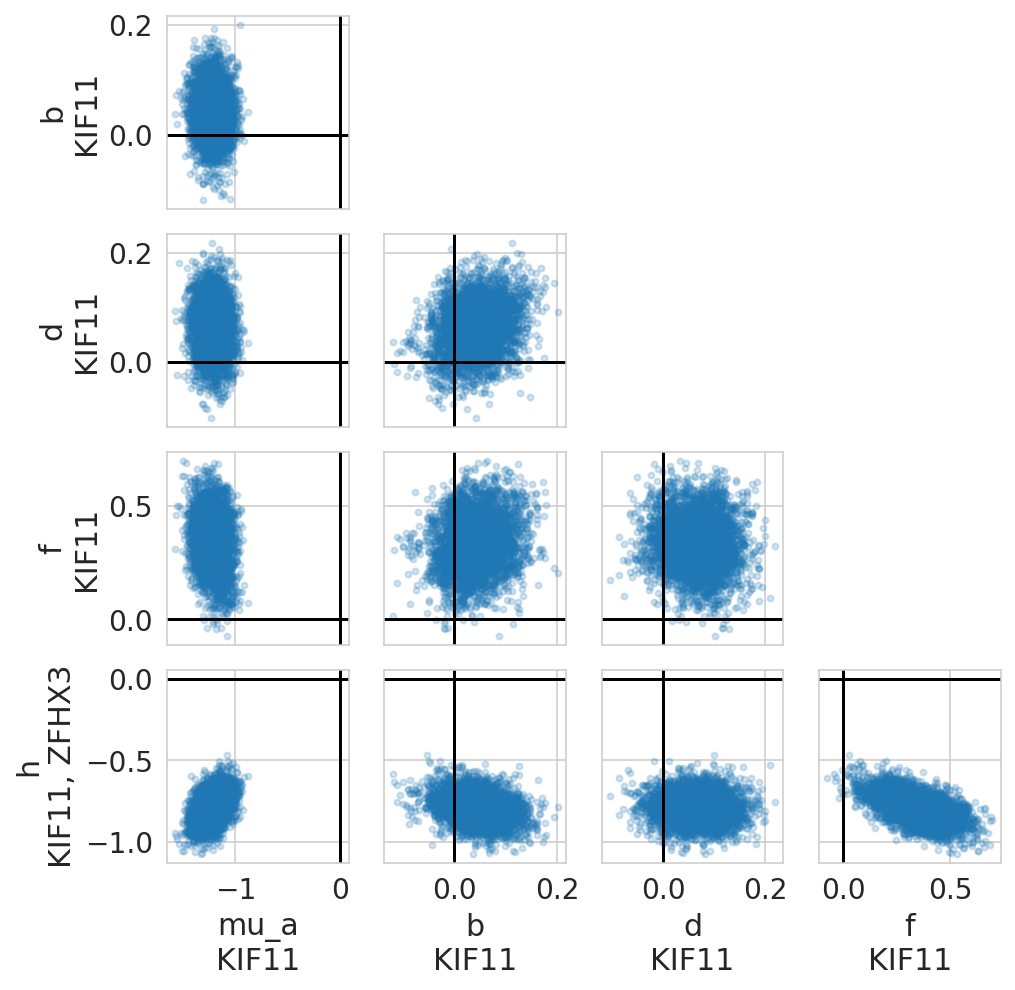

In [35]:
eg_gene = trace.posterior.coords["gene"].values[0]

for gene in [eg_gene, "KIF11"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d", "f", "h"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

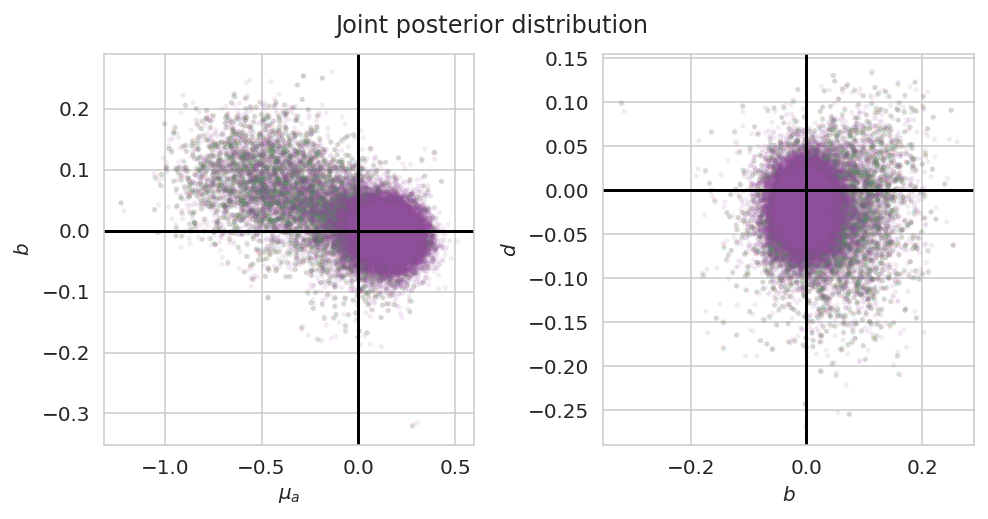

In [36]:
def _get_average_per_chain(trace: az.InferenceData, var_name: str) -> pd.DataFrame:
    return (
        trace.posterior[var_name]
        .mean(axis=(1))
        .to_dataframe()
        .reset_index()
        .astype({"chain": str})
    )


mu_a_post_avg = _get_average_per_chain(trace, "mu_a")
b_post_avg = _get_average_per_chain(trace, "b")
d_post_avg = _get_average_per_chain(trace, "d")

gene_post_avg = mu_a_post_avg.merge(b_post_avg, on=["chain", "gene"]).merge(
    d_post_avg, on=["chain", "gene"]
)


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(
    data=gene_post_avg,
    x="mu_a",
    y="b",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(
    data=gene_post_avg,
    x="b",
    y="d",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")
    ax.get_legend().remove()


fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

In [37]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d1  d2  \
genes_chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000   0   0   
genes_chol_cov_corr[0, 1] -0.383  0.013    -0.404     -0.361   0   1   
genes_chol_cov_corr[0, 2]  0.107  0.015     0.084      0.132   0   2   
genes_chol_cov_corr[0, 3] -0.483  0.032    -0.531     -0.429   0   3   
genes_chol_cov_corr[0, 4]  0.833  0.009     0.818      0.846   0   4   
genes_chol_cov_corr[1, 0] -0.383  0.013    -0.404     -0.361   1   0   
genes_chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000   1   1   
genes_chol_cov_corr[1, 2] -0.022  0.020    -0.054      0.011   1   2   
genes_chol_cov_corr[1, 3]  0.367  0.046     0.293      0.441   1   3   
genes_chol_cov_corr[1, 4] -0.538  0.015    -0.561     -0.512   1   4   
genes_chol_cov_corr[2, 0]  0.107  0.015     0.084      0.132   2   0   
genes_chol_cov_corr[2, 1] -0.022  0.020    -0.054      0.011   2   1   
genes_chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000   2   2   
genes_chol_cov_corr[2, 3] -0.100  0.044    -0.174     -0.032   2   3   
genes_chol_cov_corr[2, 4]  0.130  0.017     0.103      0.156   2   4   
genes_chol_cov_corr[3, 0] -0.483  0.032    -0.531     -0.429   3   0   
genes_chol_cov_corr[3, 1]  0.367  0.046     0.293      0.441   3   1   
genes_chol_cov_corr[3, 2] -0.100  0.044    -0.174     -0.032   3   2   
genes_chol_cov_corr[3, 3]  1.000  0.000     1.000      1.000   3   3   
genes_chol_cov_corr[3, 4] -0.666  0.026    -0.707     -0.625   3   4   
genes_chol_cov_corr[4, 0]  0.833  0.009     0.818      0.846   4   0   
genes_chol_cov_corr[4, 1] -0.538  0.015    -0.561     -0.512   4   1   
genes_chol_cov_corr[4, 2]  0.130  0.017     0.103      0.156   4   2   
genes_chol_cov_corr[4, 3] -0.666  0.026    -0.707     -0.625   4   3   
genes_chol_cov_corr[4, 4]  1.000  0.000     1.000      1.000   4   4   

                                 p1        p2  
genes_chol_cov_corr[0, 0]      mu_a      mu_a  
genes_chol_cov_corr[0, 1]      mu_a         b  
genes_chol_cov_corr[0, 2]      mu_a         d  
genes_chol_cov_corr[0, 3]      mu_a         f  
genes_chol_cov_corr[0, 4]      mu_a  h[ZFHX3]  
genes_chol_cov_corr[1, 0]         b      mu_a  
genes_chol_cov_corr[1, 1]         b         b  
genes_chol_cov_corr[1, 2]         b         d  
genes_chol_cov_corr[1, 3]         b         f  
genes_chol_cov_corr[1, 4]         b  h[ZFHX3]  
genes_chol_cov_corr[2, 0]         d      mu_a  
genes_chol_cov_corr[2, 1]         d         b  
genes_chol_cov_corr[2, 2]         d         d  
genes_chol_cov_corr[2, 3]         d         f  
genes_chol_cov_corr[2, 4]         d  h[ZFHX3]  
genes_chol_cov_corr[3, 0]         f      mu_a  
genes_chol_cov_corr[3, 1]         f         b  
genes_chol_cov_corr[3, 2]         f         d  
genes_chol_cov_corr[3, 3]         f         f  
genes_chol_cov_corr[3, 4]         f  h[ZFHX3]  
genes_chol_cov_corr[4, 0]  h[ZFHX3]      mu_a  
genes_chol_cov_corr[4, 1]  h[ZFHX3]         b  
genes_chol_cov_corr[4, 2]  h[ZFHX3]         d  
genes_chol_cov_corr[4, 3]  h[ZFHX3]         f  
genes_chol_cov_corr[4, 4]  h[ZFHX3]  h[ZFHX3]

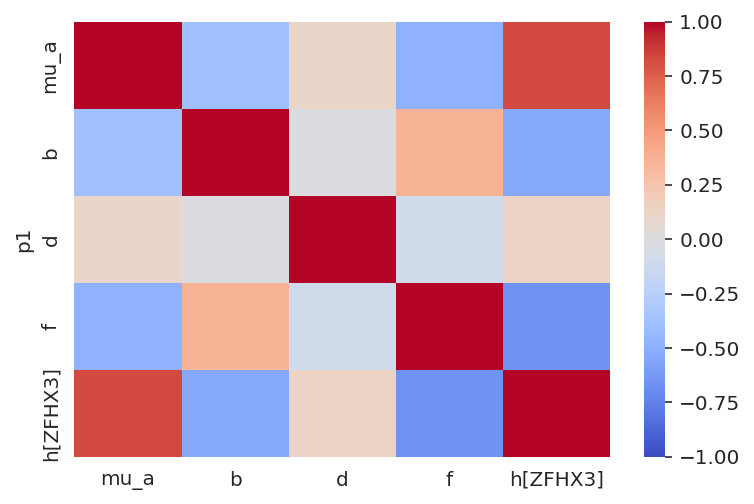

In [38]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [39]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_prostate_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

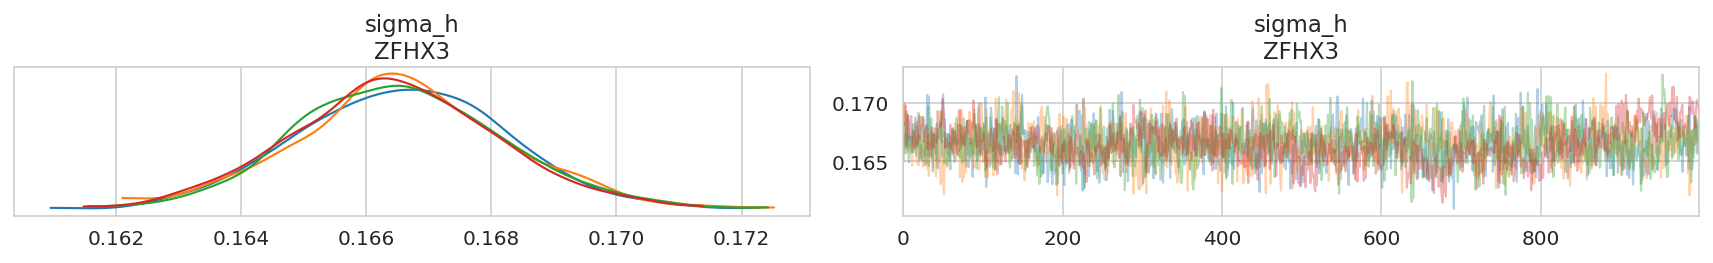

In [40]:
az.plot_trace(trace, var_names=["sigma_h"], compact=False)
plt.tight_layout()
plt.show()

In [41]:
h_post_summary = (
    prostate_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)
h_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0     h[A1BG, ZFHX3]  0.055  0.082    -0.081      0.180      0.004    0.003   
1     h[A1CF, ZFHX3]  0.123  0.082    -0.005      0.258      0.019    0.015   
2      h[A2M, ZFHX3]  0.095  0.089    -0.040      0.246      0.011    0.009   
3    h[A2ML1, ZFHX3] -0.036  0.083    -0.163      0.099      0.019    0.014   
4  h[A3GALT2, ZFHX3]  0.001  0.076    -0.120      0.125      0.007    0.005   

   ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
0     429.0     368.0   1.01        h        A1BG       ZFHX3  
1      18.0     173.0   1.15        h        A1CF       ZFHX3  
2      78.0      59.0   1.03        h         A2M       ZFHX3  
3      20.0      87.0   1.13        h       A2ML1       ZFHX3  
4     135.0     682.0   1.03        h     A3GALT2       ZFHX3

In [42]:
h_post_summary.sort_values("mean").pipe(head_tail, n=5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
4668        h[ELL, ZFHX3] -0.799  0.079    -0.921     -0.667      0.005   
7774      h[KIF11, ZFHX3] -0.786  0.084    -0.922     -0.652      0.005   
16413     h[TRNT1, ZFHX3] -0.777  0.084    -0.901     -0.635      0.015   
8393      h[LONP1, ZFHX3] -0.743  0.084    -0.876     -0.611      0.003   
1250   h[ATP6V1B2, ZFHX3] -0.729  0.083    -0.856     -0.591      0.006   
13754  h[SERPINA7, ZFHX3]  0.229  0.078     0.102      0.346      0.013   
396        h[AFF4, ZFHX3]  0.229  0.075     0.112      0.346      0.014   
4679       h[ELOA, ZFHX3]  0.260  0.068     0.154      0.369      0.003   
16203      h[TP53, ZFHX3]  0.287  0.076     0.161      0.403      0.010   
4772      h[EP300, ZFHX3]  0.504  0.077     0.377      0.623      0.005   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
4668     0.003     297.0    2304.0   1.02        h         ELL       ZFHX3  
7774     0.004     235.0    2710.0   1.02        h       KIF11       ZFHX3  
16413    0.011      33.0     786.0   1.08        h       TRNT1       ZFHX3  
8393     0.002     767.0    1915.0   1.01        h       LONP1       ZFHX3  
1250     0.004     174.0     346.0   1.02        h    ATP6V1B2       ZFHX3  
13754    0.009      38.0    1251.0   1.07        h    SERPINA7       ZFHX3  
396      0.010      30.0     956.0   1.09        h        AFF4       ZFHX3  
4679     0.002     671.0    2166.0   1.04        h        ELOA       ZFHX3  
16203    0.007      57.0     425.0   1.06        h        TP53       ZFHX3  
4772     0.004     220.0     804.0   1.01        h       EP300       ZFHX3

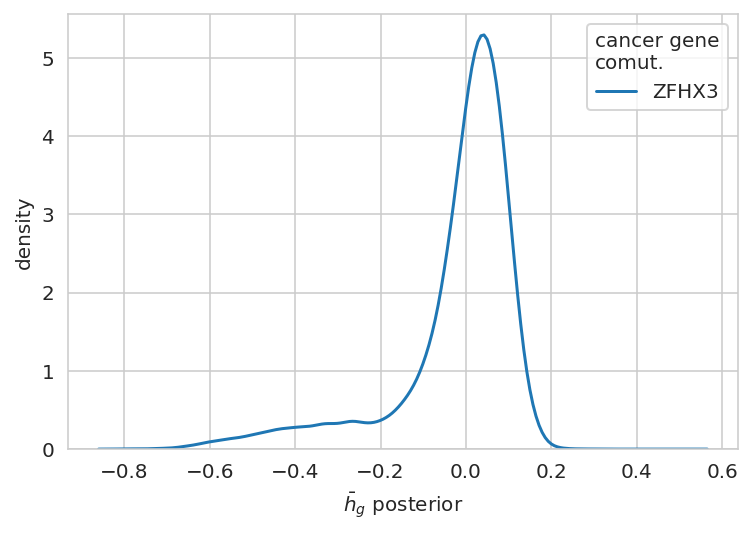

In [43]:
ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

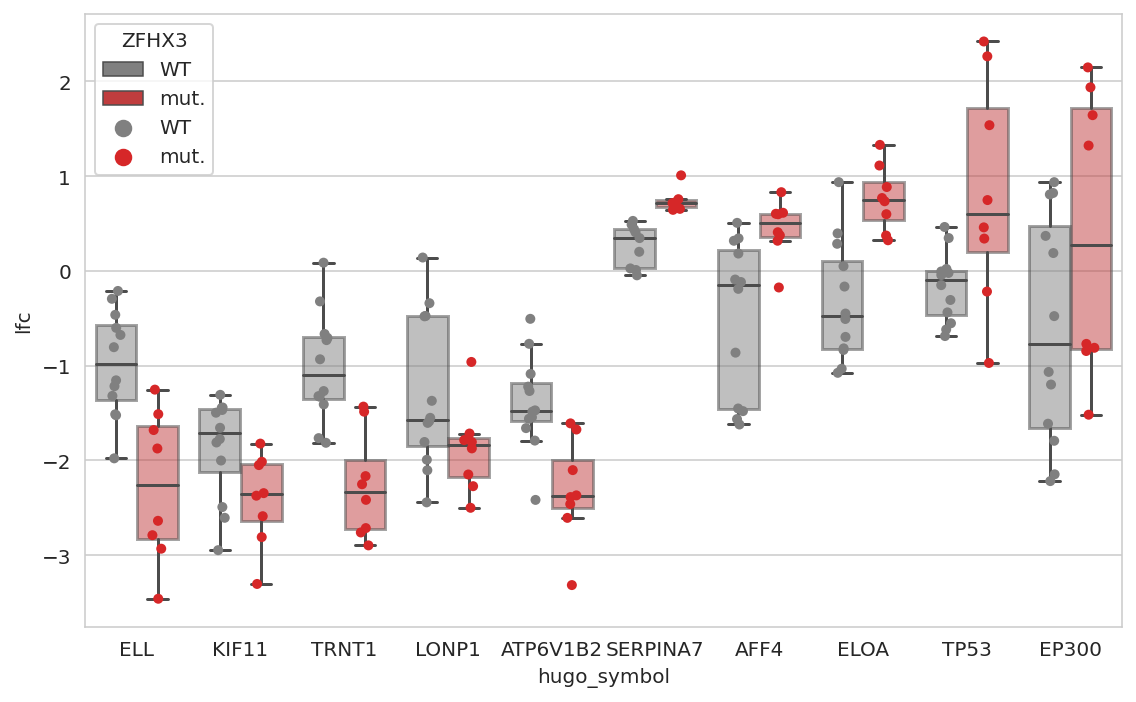

In [44]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_prostate_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    ax.get_legend().set_title(cg)

plt.tight_layout()
plt.show()

In [45]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 355308)

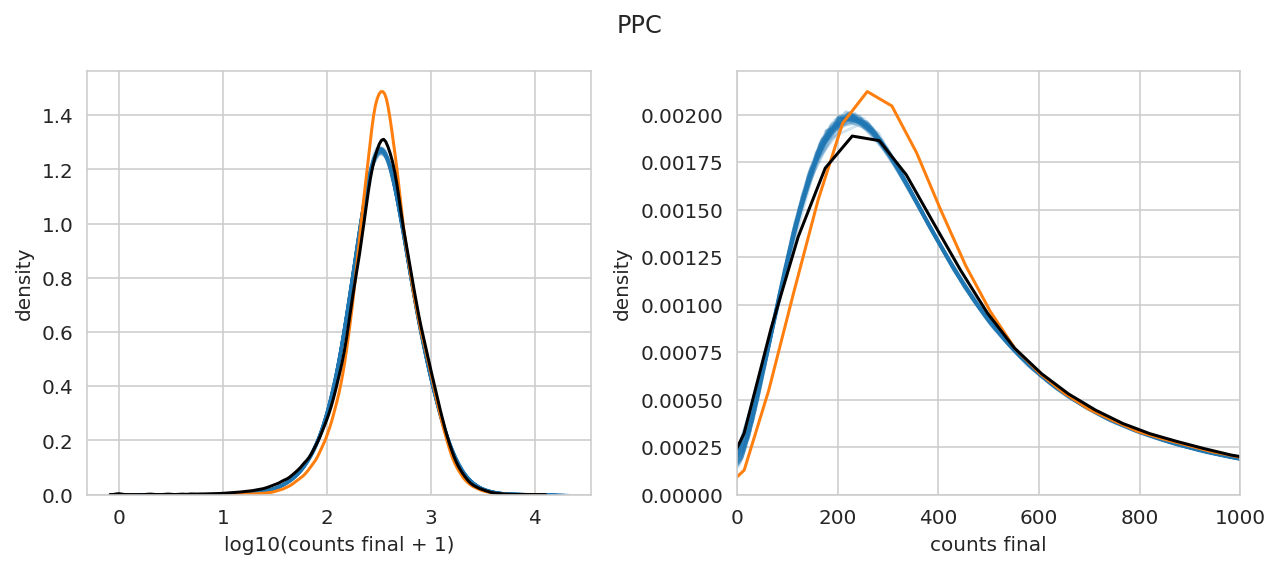

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")


for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg, color="tab:orange", ax=ax2)
sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [47]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 6.34 minutes


In [48]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-29

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.71.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: simplify

pandas    : 1.4.3
seaborn   : 0.11.2
qnorm     : 0.8.1
numpy     : 1.22.4
matplotlib: 3.5.2
pymc      : 4.1.2
scipy     : 1.8.1
arviz     : 0.12.1

